# Alto saxophone

* Sample duration = 5s
* model = SVM

Distinguish between samples with alto saxophone from those without alto saxophone. Other brass and reed instruments excluded.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, plot_precision_recall_curve, roc_curve, \
    plot_roc_curve

from sklearn.model_selection import train_test_split, \
                                    RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import uniform

In [3]:
from _alto import d, data, target, TEST_SIZE, RANDOM_SEED, NUM_COMPONENTS
# ^ this may take a while

In [4]:
x_train, x_test, y_train, y_test = train_test_split(d, target, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_SEED)

## Test plain vanilla SVM

In [5]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.9020618556701031


In [6]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,579,24
1,52,121


In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       603
           1       0.83      0.70      0.76       173

    accuracy                           0.90       776
   macro avg       0.88      0.83      0.85       776
weighted avg       0.90      0.90      0.90       776



Text(0.5, 1.0, 'Alto precision-recall curve')

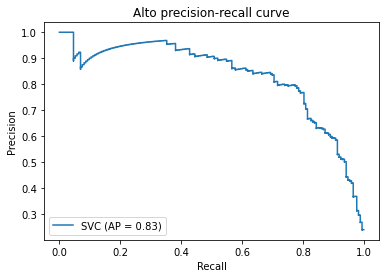

In [8]:
# fig = plt.figure(figsize=(14, 10))
disp = plot_precision_recall_curve(clf, x_test, y_test)
disp.ax_.set_title('Alto precision-recall curve')


Text(0.5, 1.0, 'Alto ROC curve')

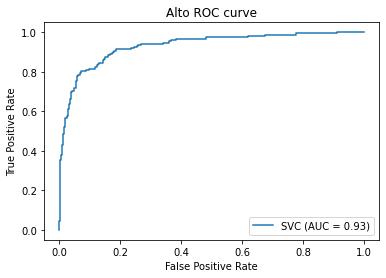

In [9]:
disp = plot_roc_curve(clf, x_test, y_test)
disp.ax_.set_title('Alto ROC curve')

## Determine good value for C using random search

In [15]:
model_params = {
    'C': uniform(0.1, 10.0)
}

# RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, 
#                    scoring=None, n_jobs=None, iid='deprecated', 
#                    refit=True, cv=None, verbose=0, 
#                    pre_dispatch='2*n_jobs', random_state=None, 
#                    error_score=nan, return_train_score=False)
svm_model = SVC()
clf = RandomizedSearchCV(svm_model, model_params, n_iter=10, cv=5)
model = clf.fit(x_train, y_train)
params = model.best_estimator_.get_params()

In [16]:
params

{'C': 7.810036433442127,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [17]:
clf = SVC(C=params['C'])
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))


0.9123711340206185


In [18]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,574,29
1,39,134


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       603
           1       0.82      0.77      0.80       173

    accuracy                           0.91       776
   macro avg       0.88      0.86      0.87       776
weighted avg       0.91      0.91      0.91       776



## Test ensemble approach with bagging classifier

#### Determine best parameters to use with bagging classifier. Start with grid search.

In [20]:
# Parameters
p = {'max_features': [NUM_COMPONENTS - 2, NUM_COMPONENTS - 3, 
                      NUM_COMPONENTS - 4, NUM_COMPONENTS - 5,
                      NUM_COMPONENTS - 6, NUM_COMPONENTS - 7,
                      NUM_COMPONENTS - 8, NUM_COMPONENTS - 9]}

base_estimator = SVC(C=params['C'])
estimator = BaggingClassifier(base_estimator=base_estimator, n_estimators=100)
# Question: Should we include C here, or ... ? There's no reason it should differ
# for different values of n_estimators, but what about max_features? Might different
# values for C be best for different max_features? Maybe. Dunno. Maybe we should
# search for optimal C *after* we've found the best value for max_features?

# GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, 
#              iid='deprecated', refit=True, cv=None, verbose=0, 
#              pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
clf = GridSearchCV(estimator, p, n_jobs=-1)
search = clf.fit(x_train, y_train)
search.best_params_

# {'max_features': 35}

{'max_features': 35}

In [21]:
# RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, 
#                    n_jobs=None, iid='deprecated', refit=True, cv=None, 
#                    verbose=0, pre_dispatch='2*n_jobs', random_state=None, 
#                    error_score=nan, return_train_score=False)
# clf = RandomizedSearchCV(estimator, pds, random_state=RANDOM_STATE, verbose=1)

In [22]:
# BaggingClassifier(base_estimator=None, n_estimators=10, *, 
#                   max_samples=1.0, max_features=1.0, 
#                   bootstrap=True, bootstrap_features=False, 
#                   oob_score=False, warm_start=False, 
#                   n_jobs=None, random_state=None, verbose=0) 
base_estimator = SVC(C=params['C'])
clf = BaggingClassifier(base_estimator=base_estimator,
                        n_estimators=500, 
                        max_features=search.best_params_['max_features'],
                        random_state=RANDOM_SEED,
                        n_jobs=-1)
model = clf.fit(x_train, y_train)

In [23]:
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.9149484536082474


In [24]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,581,22
1,44,129


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       603
           1       0.85      0.75      0.80       173

    accuracy                           0.91       776
   macro avg       0.89      0.85      0.87       776
weighted avg       0.91      0.91      0.91       776



### Try weakening our learners. Maybe bagging will work better then.

* Reduce training set size (increase test set size)
* Do not optimize C
* Explore wider range of parameters in grid search

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d, target, 
                                                    test_size=0.4, 
                                                    random_state=RANDOM_SEED)

In [ ]:
# Parameters
p = {'n_estimators': [50, 75, 100, 200, 300, 400],
     'max_features': [NUM_COMPONENTS - 2, NUM_COMPONENTS - 3, 
                      NUM_COMPONENTS - 4, NUM_COMPONENTS - 5,
                      NUM_COMPONENTS - 6, NUM_COMPONENTS - 7]}

base_estimator = SVC()
estimator = BaggingClassifier(base_estimator=base_estimator)

# GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, 
#              iid='deprecated', refit=True, cv=None, verbose=0, 
#              pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
clf = GridSearchCV(estimator, p, n_jobs=-1)
search = clf.fit(x_train, y_train)
search.best_params_

# {'max_features': 43, 'n_estimators': 100}

In [ ]:
# BaggingClassifier(base_estimator=None, n_estimators=10, *, 
#                   max_samples=1.0, max_features=1.0, 
#                   bootstrap=True, bootstrap_features=False, 
#                   oob_score=False, warm_start=False, 
#                   n_jobs=None, random_state=None, verbose=0) 
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=search.best_params_['n_estimators'], 
                        max_features=search.best_params_['max_features'],
                        random_state=RANDOM_SEED,
                        n_jobs=-1)
model = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
pca = PCA(0.90).fit(data)
print(pca.n_components_)
d90 = pca.transform(data)

In [ ]:
x_train, x_test, y_train, y_test = \
     train_test_split(d90, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [ ]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
pca = PCA(0.85).fit(data)
print(pca.n_components_)
d85 = pca.transform(data)

In [ ]:
x_train, x_test, y_train, y_test = \
     train_test_split(d85, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [ ]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
pca = PCA(0.75).fit(data)
print(pca.n_components_)
d75 = pca.transform(data)

In [ ]:
x_train, x_test, y_train, y_test = \
     train_test_split(d75, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [ ]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
pca = PCA(0.50).fit(data)
print(pca.n_components_)
d50 = pca.transform(data)

In [ ]:
x_train, x_test, y_train, y_test = \
     train_test_split(d50, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [ ]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

In [ ]:
print(classification_report(y_test, y_pred))